In [1]:
%matplotlib inline
import pyspeckit
import numpy as np
from astropy import units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
from c_normalize import c_normalize


## Basic Plotting and Fitting

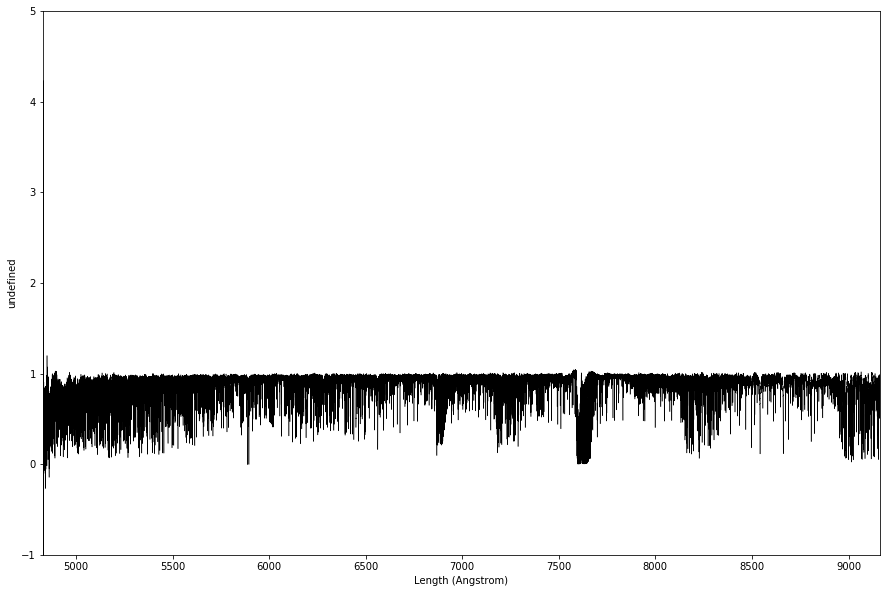

In [2]:
s_hdu = fits.open("Data/ew_known/tame_inputs/col110_1134red_oned_25jan14_wavsoln.fits")
fig = plt.figure(figsize=(15,10))

s_data = s_hdu[1].data
s_flux = s_data['FLUX']
s_wav = s_data['WAVEL'] * u.AA
sp = pyspeckit.Spectrum(data=s_flux, xarr=s_wav)
sp.plotter(figure=fig, ymin = -1, ymax = 5)

In [3]:
#s_hdu[0].header

[0.6666667  1.         0.68230957 ... 0.26774517 0.26264656 0.17260873]



Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


-2.07380749287152


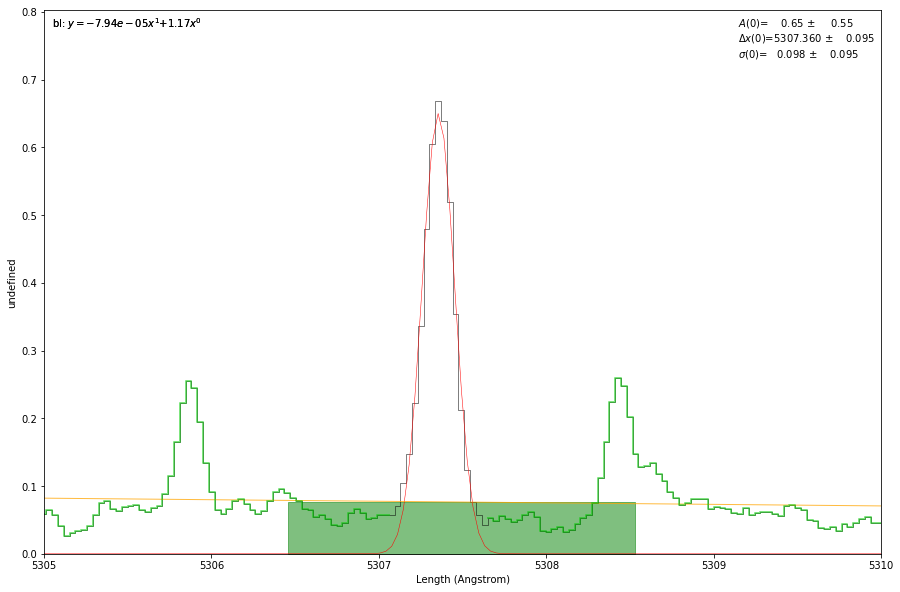

In [4]:
s_hdu = fits.open("Data/ew_known/tame_inputs/col110_1134red_oned_25jan14_wavsoln.fits")
#spec_lpx = pd.read_csv("Data/ew_known/tame_inputs/col110_1134red_oned_25jan14.lpx",
                       #delim_whitespace = True, header=None)
fig = plt.figure(figsize=(15,10))

s_data = s_hdu[1].data
s_flux = abs(s_data['FLUX'] - 1.)

smoothed_flux = convolve(s_flux, Box1DKernel(3))
s_flux = smoothed_flux
#s_flux = s_data['FLUX']*np.array(spec_lpx[1])
print(s_flux)
s_wav = s_data['WAVEL'] * u.AA
sp = pyspeckit.Spectrum(data=s_flux, xarr=s_wav)
sp.plotter(figure = fig, xmin=5305, xmax=5310., ymin = 0)

sp.specfit(fittype='gaussian', guesses = [0.5, 5307.36, 0.1])
#sp.specfit(fittype='voigt', guesses = 'moments')
sp.baseline(subtract=False, highlight_fitregion=True, excludefit = True)
print(sp.specfit.EQW(plot=True, continuum_as_baseline=True))

sp.plotter.savefig('basic_plot_example_withfit.png')


Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


EQW: -3.067333468717257e-43 mA


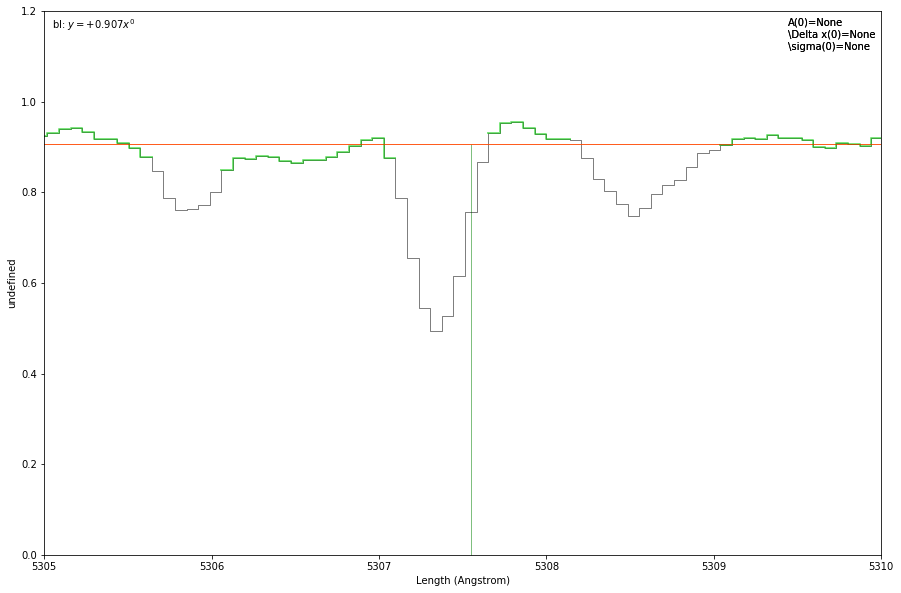

In [5]:
s_hdu = fits.open("Data/ew_known/tame_inputs/col110_1134red_oned_25jan14_wavsoln.fits")
s_hdu = fits.open("data/ew_known/tame_inputs/ngc6583_42red_oned_slit07_jun14_wavsoln.fits")
fig = plt.figure(figsize=(15,10))

s_data = s_hdu[1].data
s_flux = s_data['FLUX']
smoothed_flux = convolve(s_flux, Box1DKernel(5))
s_flux = smoothed_flux
s_wav = s_data['WAVEL'] * u.AA
sp = pyspeckit.Spectrum(data=s_flux, xarr=s_wav)
sp.plotter(figure = fig, xmin=5305, xmax=5310., ymin=0, ymax=1.2)

sp.baseline(order=0, subtract=False, highlight_fitregion=True, exclude=[5305.7,5306,5307.1,5307.6,5308.2,5309])
            
sp.specfit(fittype='gaussian', guesses = [0.1, 5307.36, 0.1])
EQW = sp.specfit.EQW(plot=True, continuum = 0.95)
print("EQW:", EQW*1000*u.mA)

sp.plotter.savefig('basic_plot_example_withfit.png')



## Try c_normalize

ct_fit < npoly+1


The fit may be poorly conditioned


0.09546135734610446
EQW: [ 98.87988322 294.59831177  58.07762578] mA



Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


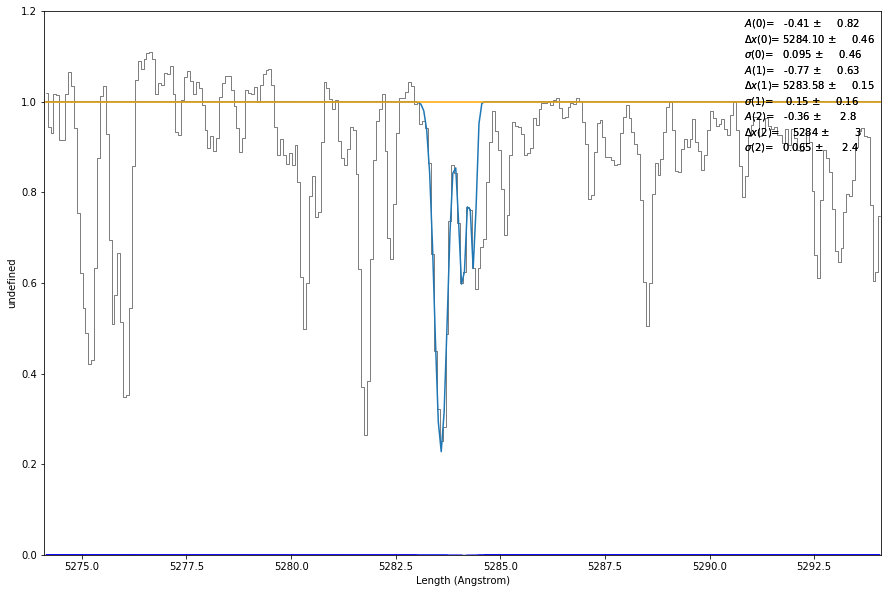

In [6]:
s_hdu = fits.open("data/ew_known/tame_inputs/ngc6583_39red_oned_slit07_jun14_wavsoln.fits")
#s_hdu = fits.open("data/ew_known/tame_inputs/ngc6583_10red_oned_slit05_jun14_wavsoln.fits")
fig = plt.figure(figsize=(15,10))

line_cen = 5284.1
width = 10
lim_l = line_cen - width
lim_r = line_cen + width


s_data = s_hdu[1].data
s_flux = s_data['FLUX']
#smoothed_flux = convolve(s_flux, Box1DKernel(5))
#s_flux = smoothed_flux
s_wav = s_data['WAVEL']

wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
s_flux = s_flux[wav_mask]
s_wav = s_wav[wav_mask]
yfit, norm, pts = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.99)

sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)
sp.plotter(figure = fig, xmin=lim_l, xmax=lim_r, ymin=0, ymax=1.2)

#Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
#sp.baseline(order=0, subtract=False, highlight_fitregion=False)
sp.baseline.basespec = np.ones(len(s_wav))
sp.specfit(fittype='gaussian', guesses = [-0.3, line_cen, 0.15, -0.7, line_cen-0.3, 0.15, -0.3, line_cen+0.2, 0.15], exclude= [0,line_cen-1, line_cen+0.3, line_cen+5000], show_components=True)
model = sp.specfit.get_model_frompars(s_wav, sp.specfit.parinfo)
print(sp.specfit.parinfo[2].value)
plt.plot(s_wav,model + 1)
#plt.plot(s_wav,model1 + 1)
EQW = sp.specfit.EQW(plot=False, continuum = 1.0, continuum_as_baseline=False,xmin=0, xmax = len(norm), components=True)
print("EQW:", np.array(EQW)*1000*u.mA)
plt.axhline(1, color = 'orange')
#plt.plot(s_wav, yfit)
#sp.plotter.savefig('basic_plot_example_withfit.png')

The fit may be poorly conditioned


EQW: [62.49306054 21.92086146] mA



Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


(0.01, 1.2)

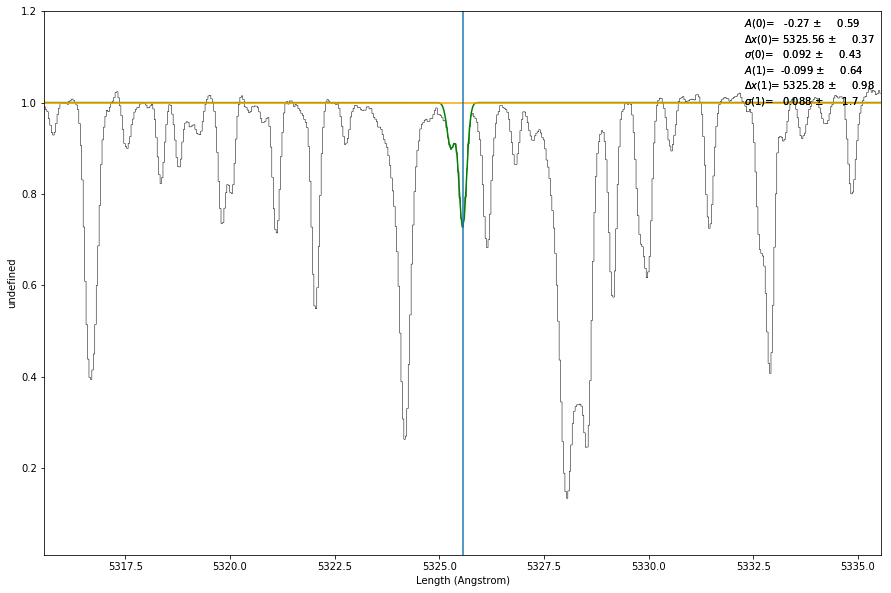

In [36]:
#s_hdu = fits.open("data/ew_known/tame_inputs/ngc2204_4223red_oned_05jan14_wavsoln.fits")
#s_hdu = fits.open("Data/ew_known/tame_inputs/ngc6583_39red_oned_slit07_jun14_wavsoln.fits")
s_hdu = fits.open("data/ew_known/tame_inputs/col110_1134red_oned_25jan14_wavsoln.fits")
fig = plt.figure(figsize=(15,10))

line_cen = 5325.56
width = 10
lim_l = line_cen - width
lim_r = line_cen + width


s_data = s_hdu[1].data
s_flux = s_data['FLUX']
smoothed_flux = convolve(s_flux, Box1DKernel(5))
s_flux = smoothed_flux
s_wav = s_data['WAVEL']

wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
s_flux = s_flux[wav_mask]
s_wav = s_wav[wav_mask]
yfit, norm, pts = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.91)

sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)
sp.plotter(figure = fig, xmin=lim_l, xmax=lim_r, ymin=0, ymax=1.2)

#Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
#sp.baseline(order=0, subtract=False, highlight_fitregion=False)
sp.baseline.basespec = np.ones(len(s_wav))

sp.specfit(fittype='gaussian', guesses = [-0.3, line_cen, 0.15, -0.1, line_cen-0.25, 0.15], exclude= [0,line_cen-0.4, line_cen+0.18, line_cen+5000], show_components=True)
#sp.specfit(fittype='gaussian', guesses = [-0.4, line_cen+0.1, 0.15, -0.4, line_cen, 0.15], exclude= [0,line_cen-2, line_cen+2, line_cen+5000], show_components=True)
model = sp.specfit.get_model_frompars(s_wav, sp.specfit.parinfo)
plt.plot(s_wav,model + 1, color = 'g')

EQW = sp.specfit.EQW(plot=False, continuum = 1.0, continuum_as_baseline=False, xmin=0,xmax=len(norm), components=True)
print("EQW:", np.array(EQW)*1000*u.mA)
plt.axhline(1, color = 'orange')
plt.axvline(line_cen)
plt.ylim([0.01, 1.2])
#plt.plot(s_wav, s_flux)
#sp.plotter.savefig('basic_plot_example_withfit.png')

The fit may be poorly conditioned


EQW: [155.80001139] mA



Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


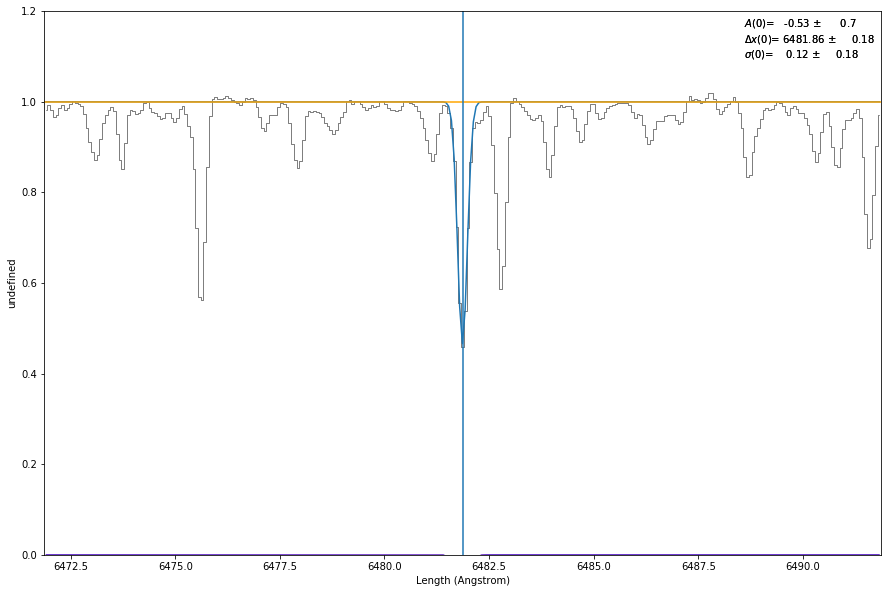

In [57]:
s_hdu = fits.open("data/ew_known/tame_inputs/ngc2204_2212red_oned_05jan14_wavsoln.fits")

#s_hdu = fits.open("data/ew_known/tame_inputs/ngc6583_10red_oned_slit05_jun14_wavsoln.fits")
fig = plt.figure(figsize=(15,10))


left = 0.3
right=0.3

line_cen = 6481.87
width = 10
lim_l = line_cen - width
lim_r = line_cen + width


s_data = s_hdu[1].data
s_flux = s_data['FLUX']
#smoothed_flux = convolve(s_flux, Box1DKernel(5))
smoothed_flux = s_flux
s_flux = smoothed_flux
s_wav = s_data['WAVEL']

wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
s_flux = s_flux[wav_mask]
s_wav = s_wav[wav_mask]
yfit, norm, pts = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.99)

sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)
sp.plotter(figure = fig, xmin=lim_l, xmax=lim_r, ymin=0, ymax=1.2)

#Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
#sp.baseline(order=0, subtract=False, highlight_fitregion=False)
sp.baseline.basespec = np.ones(len(s_wav))
sp.specfit(fittype='gaussian', guesses = [-0.3, line_cen, 0.15], exclude= [0,line_cen-left, line_cen+right, line_cen+5000], show_components=True)
model = sp.specfit.get_model_frompars(s_wav, sp.specfit.parinfo)
plt.plot(s_wav,model + 1)
#plt.plot(s_wav,model1 + 1)
EQW = sp.specfit.EQW(plot=False, continuum = 1.0, continuum_as_baseline=False,xmin=0, xmax = len(norm), components=True)
print("EQW:", np.array(EQW)*1000*u.mA)
plt.axhline(1, color = 'orange')
plt.axvline(line_cen)
#plt.axvline(line_cen -0.35)
#plt.axvline(line_cen+0.35)
#plt.axvline(line_cen +right, color='g',alpha=0.5)
#plt.axvline(line_cen-left, color='g',alpha=0.5)
#plt.plot(s_wav, yfit)
#plt.ylim(0.8,1.2)
#plt.xlim(5836.0, 5841.0)
#sp.plotter.savefig('basic_plot_example_withfit.png')

The fit may be poorly conditioned


0.1087994182058322
EQW: [85.42209848] mA



Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


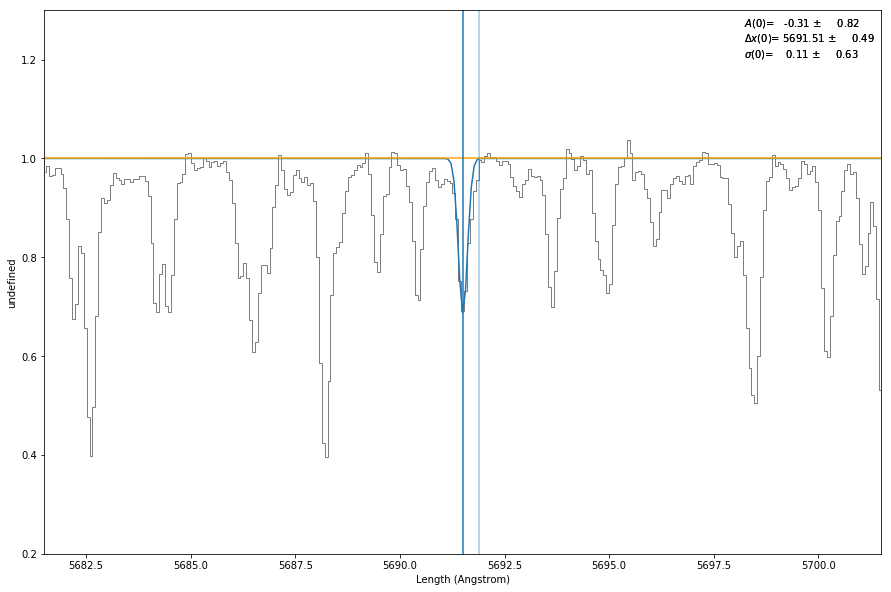

In [46]:
s_hdu = fits.open("data/ew_known/tame_inputs/ngc6583_72red_oned_slit07_jun14_wavsoln.fits")
#s_hdu = fits.open("data/ew_known/tame_inputs/ngc2204_3215red_oned_05jan14_wavsoln.fits")
fig = plt.figure(figsize=(15,10))

line_cen = 5691.5
width = 10
lim_l = line_cen - width
lim_r = line_cen + width


s_data = s_hdu[1].data
s_flux = s_data['FLUX']
#smoothed_flux = convolve(s_flux, Box1DKernel(5))
#s_flux = smoothed_flux
s_wav = s_data['WAVEL']

wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
s_flux = s_flux[wav_mask]
s_wav = s_wav[wav_mask]
yfit, norm, pts = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.99)

sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)
sp.plotter(figure = fig, xmin=lim_l, xmax=lim_r, ymin=0, ymax=1.2)

#Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
#sp.baseline(order=0, subtract=False, highlight_fitregion=False)
sp.baseline.basespec = np.ones(len(s_wav))
#sp.specfit(fittype='gaussian', guesses = [-0.3, line_cen, 0.15, -0.01, line_cen +0.3, 0.15], exclude= [0,line_cen-0.3, line_cen+0.4, line_cen+5000], show_components=True)
sp.specfit(fittype='gaussian', guesses = [-0.3, line_cen, 0.15], exclude= [0,line_cen-0.2, line_cen+0.15, line_cen+5000], show_components=True)
model = sp.specfit.get_model_frompars(s_wav, sp.specfit.parinfo)
print(sp.specfit.parinfo[2].value)
plt.plot(s_wav,model + 1)
#plt.plot(s_wav,model1 + 1)
EQW = sp.specfit.EQW(plot=False, continuum = 1.0, continuum_as_baseline=False,xmin=0, xmax = len(norm),components=True)
print("EQW:", np.array(EQW)*1000*u.mA)
plt.axhline(1, color = 'orange')
plt.axvline(line_cen)
plt.ylim(0.2,1.3)
#plt.xlim(5708,5715)
plt.axvline(line_cen+0.4, alpha=0.4)
#plt.axvline(line_cen-0.6, alpha=0.4)
#plt.plot(s_wav, yfit)
#sp.plotter.savefig('basic_plot_example_withfit.png')